In [1]:
import os
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-15 01:40:43.247258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 01:40:44.206406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 71936 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [2]:
# import data
import os
import numpy as np
gpath = "/home/abhijit/anik/datasets/tf-qdata/full-pneumonia/"
print(os.path.exists(gpath))
X_train = np.load(gpath + "xtrain.npy")
X_test = np.load(gpath + "xtest.npy")
X_valid = np.load(gpath + "xvalid.npy")

y_train = np.load(gpath + "ytrain.npy")
y_test = np.load(gpath + "ytest.npy")
y_valid = np.load(gpath + "yvalid.npy")

True


In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
from functools import reduce

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
y_valid.shape

(500, 3)

In [5]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [
            cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    # nums = [[0, 4], [0]]
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    # cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[5:])]
    # cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[6:])]
    # cz_ops = ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    # cz_ops = None
    return cz_ops

In [6]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

In [7]:
n_qubits, n_layers = 12, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
# print(circuit)

In [8]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)
        self.observables = observables

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)
        self.circuit = circuit

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(self.circuit, self.observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_layers': self.n_layers,
            'n_qubits': self.n_qubits,
            'theta': self.theta,
            'lmdb': self.lmbd,
            'indices': self.indices,
            'activation': self.activation,
            'empty_circuit': self.empty_circuit,
            'computation_layer': self.computation_layer,
            'circuit': self.circuit,
            'observables': self.observables
        })
        return config


In [9]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [10]:
n_qubits = 12 # Dimension of the state vectors in CartPole
n_layers = 10 # Number of layers in the PQC
n_actions = 3 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)

In [11]:
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

In [12]:
def generate_model_policy(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC policy."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Dense(32, activation="relu"),
        # tf.keras.layers.Softmax()
        tf.keras.layers.Dense(3, activation="softmax"),
    ], name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=policy)

    return model

model = generate_model_policy(qubits, n_layers, n_actions, 1.0, observables)

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 re-uploading_PQC (ReUploadi  (None, 1)                516       
 ngPQC)                                                          
                                                                 
 observables-policy (Sequent  (None, 3)                230       
 ial)                                                            
                                                                 
Total params: 746
Trainable params: 746
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [16]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_valid = tf.convert_to_tensor(X_valid)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_valid = tf.convert_to_tensor(y_valid)

In [17]:
y_valid.shape

TensorShape([500, 3])

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,
                                            restore_best_weights=True,
                                            mode='auto')
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/q-CNN.h5", 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='auto')

In [19]:
history = model.fit(X_train,
                    y_train,
                    batch_size = 128,
                    epochs = 20,
                    verbose = 1,
                    callbacks = [early_stop],
                    validation_data = (X_valid, y_valid))

Epoch 1/20


2023-07-15 01:40:52.486841: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 120s 3s/step - loss: 1.0650 - categorical_accuracy: 0.6318 - val_loss: 1.0179 - val_categorical_accuracy: 0.6640
Epoch 2/20
37/37 [==============================] - 115s 3s/step - loss: 0.9495 - categorical_accuracy: 0.8129 - val_loss: 0.8732 - val_categorical_accuracy: 0.8740
Epoch 3/20
37/37 [==============================] - 115s 3s/step - loss: 0.7652 - categorical_accuracy: 0.9106 - val_loss: 0.6769 - val_categorical_accuracy: 0.8880
Epoch 4/20
37/37 [==============================] - 114s 3s/step - loss: 0.5561 - categorical_accuracy: 0.9106 - val_loss: 0.5017 - val_categorical_accuracy: 0.8880
Epoch 5/20
37/37 [==============================] - 115s 3s/step - loss: 0.3852 - categorical_accuracy: 0.9242 - val_loss: 0.3604 - val_categorical_accuracy: 0.9700
Epoch 6/20
37/37 [==============================] - 114s 3s/step - loss: 0.2447 - categorical_accuracy: 0.9996 - val_loss: 0.2488 - val_categorical_accuracy: 0.9720
Epoch 7/20
37/37 [===

Performance parameters and graph for hybrid-qnn
Accuracy - Train: 1.000, Test: 0.959 
Loss - Train: 0.019, Test: 0.169 



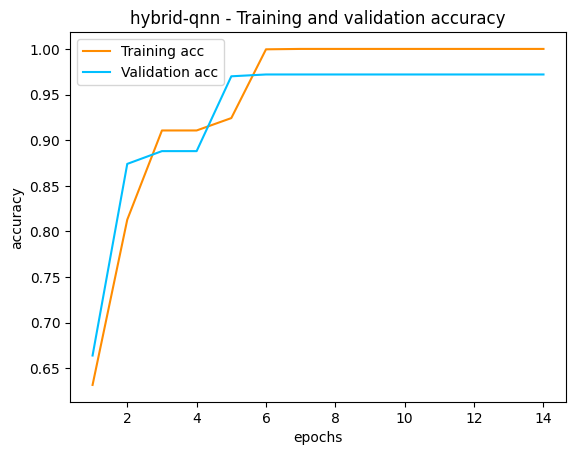

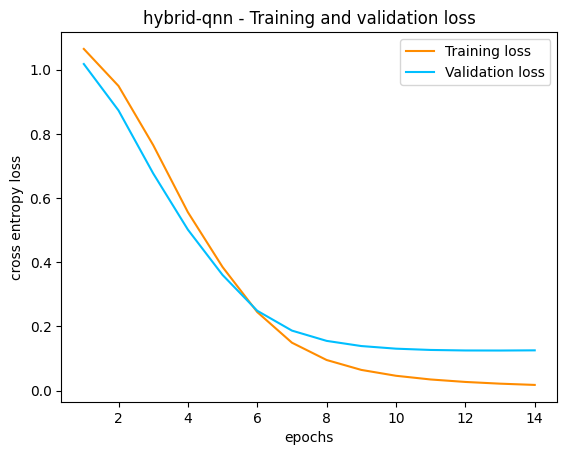

In [20]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, history, name, flag=False):
    print(f"Performance parameters and graph for {name}")
    # evaluate the model

    train_loss, train_acc =  model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy - Train: %.3f, Test: %.3f ' % (train_acc, test_acc))
    print('Loss - Train: %.3f, Test: %.3f \n' % (train_loss, test_loss))
    # learning curves of model accuracy
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, "darkorange", label='Training acc')
    plt.plot(epochs, val_acc, "deepskyblue", label='Validation acc')
    plt.title(f'{name} - Training and validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'darkorange', label='Training loss')
    plt.plot(epochs, val_loss, 'deepskyblue', label='Validation loss')
    plt.title(f'{name} - Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("cross entropy loss")
    plt.legend()
    plt.show()

# model = tf.keras.models.load_model("models/q-CNN.h5")
evaluate_and_plot(model, history, "hybrid-qnn")